In [1]:
#- Scientific stack
import numpy as np
import matplotlib.pyplot as plt

#- Graph-stats
from dkps.dkps import DataKernelPerspectiveSpace
from dkps.utils import knn_graph, get_cdf, bootstrap_null

from graspologic.embed import OmnibusEmbed

#- Transformers / embedding models
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
 
#- Utils
import gc
import torch
from tqdm import tqdm

In [2]:
#- get some toy data
n_documents=100
dataset = load_dataset("yahoo_answers_topics", split=f'train[:{n_documents}]', trust_remote_code=True)['best_answer']
print(dataset[:2])

['Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.', 'i hear that the mojave road is amazing!<br />\\nsearch for it online.']


In [3]:
#- pick two embedding functions to compare, get embeddings.
#- NOTE: these embedding functions are not related at a foundation model, per se
#- replace them with however you want to get model-specific embeddings
embedding_functions = ['nomic-ai/nomic-embed-text-v1.5', 'sentence-transformers/all-MiniLM-L6-v2']

embd_dict = {}
for embed_function in embedding_functions:
    embedding_model = SentenceTransformer(embed_function, trust_remote_code=True, device='cuda:0')
    embd_dict[embed_function] = embedding_model.encode(dataset)
    
    #- GPU vRAM hygiene
    del embedding_model
    torch.cuda.empty_cache()
    gc.collect()

<All keys matched successfully>


nomic-ai/nomic-embed-text-v1.5 (100, 768)
sentence-transformers/all-MiniLM-L6-v2 (100, 384)


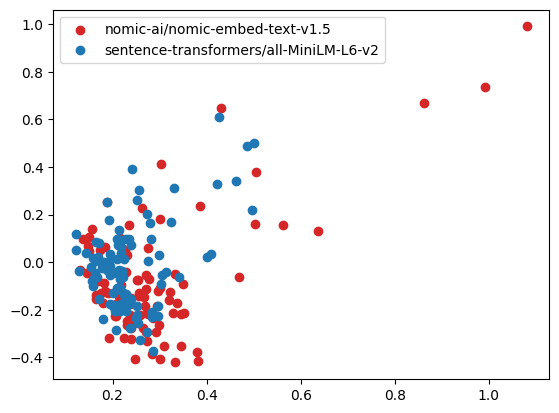

In [4]:
#- embedding dimensions are not the same; further, even if they were there's no guarantee that they share the same basis.
for embed_function in embedding_functions:
    print(embed_function, embd_dict[embed_function].shape)
    
#- we can mod out dimension / basis differences by considering the k-NN graphs
k=int(np.log(n_documents))
knn_graphs = {}
for embed_function in embedding_functions:
    temp_knn_graph = knn_graph(embd_dict[embed_function], k=k, symmetrize=True, metric='cosine')
    knn_graphs[embed_function] = temp_knn_graph

#- now, we can "easily" learn a joint/aligned low-dimensional embedding of the two sets of embeddings
omni_embds = OmnibusEmbed(n_components=2).fit_transform(list(knn_graphs.values()))
fig, ax = plt.subplots(1,1)

colors = ['tab:red', 'tab:blue']

for i, embed_function in enumerate(embedding_functions):
    ax.scatter(omni_embds[i, :, 0], omni_embds[i, :, 1], c=colors[i], label=embed_function)
    
ax.legend(loc='upper left')

In [5]:
#- A simple "check" to see if the two embedding functions represent document i differently
#- is to look at the distance || omni[0][i] - omni[1][i] ||
argsorted=np.argsort(np.linalg.norm(omni_embds[0] - omni_embds[1], axis=1))
print(argsorted)

#- i.e., dataset[argsorted[0]] has moved the most

[39  8  7 15 28 35 72 19 54  2 53  0  4 45 50 20 94 55 82 69 77 14 23  6
 48 38 22 65 44 18 71 31 67 75 84 46 36 32 12 86 80 42 49 96 10 95 97 76
 17 73  5 91 27 26  3 92 93 16 78 59 63 33 51 37 70 68 25 62 24 47 83 66
 21 30 60 40 90 29 79 88 58 87 11 74 34 98  9 81 41  1 85 52 89 99 43 56
 57 61 64 13]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 320.98it/s]


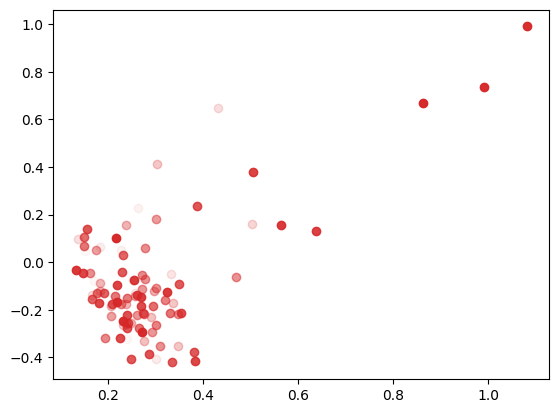

In [6]:
#- A more statistically rigorous way to determine *if* a document has moved
#- is to use the hypothesis test described in the paper

null_dist = bootstrap_null(knn_graphs['nomic-ai/nomic-embed-text-v1.5'], number_of_bootstraps=100)[0]
test_statistics = np.linalg.norm(omni_embds[0] - omni_embds[1], axis=1)
p_values = []
for i, test_statistic in enumerate(test_statistics):
    p_value = np.mean(test_statistic < null_dist[i])
    p_values.append(p_value)
    
    
#- same joint embedding space as above, but this time just plotting nomic-ai/nomic-embed-text-v1.5
#- and adding color intensity to represent p-value
fig, ax = plt.subplots(1,1)
for j in range(n_documents):
    ax.scatter(omni_embds[0, j, 0], omni_embds[0, j, 1], label=embed_function, color=colors[0], alpha=1-p_values[j])

[39 35 28  7 72 15 19  8  2 53 54 45 94  0 55 20 71 50  4 69 80 23 16 42
 67 46 14 75 84 44 86 18 77 65 73 82 38 12 26 30 96 92 51  5 29 36 10  6
 17 76 32 27 60 41 87 49 48 97 66 78 98 62 22 21 31 59 70 37  9 47 91 33
 34 24 68  3 88 79 52 40 81 83 25 95 43 74 63 57 85 11 89  1 93 58 13 64
 99 90 56 61]


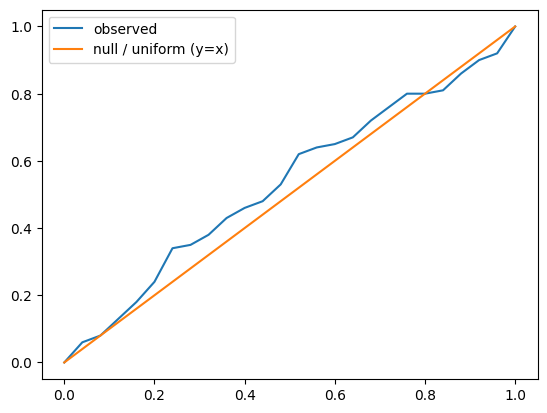

In [7]:
#- Notice that the ranking of the p-values is related to but does not equal ranking of || omni[0][i] - omni[1][i] ||
print(np.argsort(p_values)[::-1])

#- Looking at distribution of p-values relative to the uniform dist
#- there doesnt seem to be a systematic difference

linspace=np.linspace(0, 1, num=25+1)
cdf  = get_cdf(p_values, num=25+1)

fig, ax = plt.subplots(1,1)

ax.plot(linspace, cdf, label='observed')
ax.plot(linspace, linspace, label='null / uniform (y=x)')
ax.legend()

In [8]:
#- We can also use the data kernel to compare represent the embedding models themselves
#- NOTE: some of the models below require non-trivial disk space / GPU vRAM
embedding_functions = [
    'nomic-ai/nomic-embed-text-v1.5', 
    'sentence-transformers/all-MiniLM-L6-v2',
    'BAAI/bge-m3',
    'sentence-transformers/all-mpnet-base-v2',
    'BAAI/bge-small-en-v1.5',
]

embd_dict = {}
for embed_function in embedding_functions:
    embedding_model = SentenceTransformer(embed_function, trust_remote_code=True, device='cuda:0')
    embd_dict[embed_function] = embedding_model.encode(dataset)
    
    #- GPU vRAM hygiene
    del embedding_model
    torch.cuda.empty_cache()
    gc.collect()
    
dkps_embds = DataKernelPerspectiveSpace(n_neighbors=8, metric='cosine').fit_transform(embd_dict)

<All keys matched successfully>


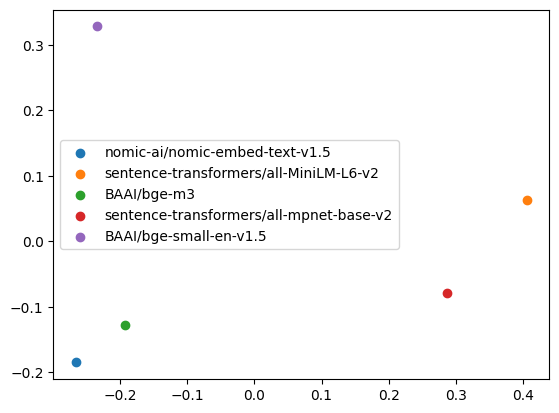

In [9]:
fig, ax = plt.subplots(1,1)

#- Get low-dimensional representations of embedding models.
#- "Families" of embedding models are close to each other in this space.

for i, dkps in enumerate(dkps_embds):
    ax.scatter(dkps[0], dkps[1], label=embedding_functions[i])
ax.legend(loc='center left')